# TPU Training Code for EfficientNet B4
* Sigmoid Focal Cross Entropy Loss with Label Smoothing 0.1
* Learning Rate Sheduler with Warmup and Cosine Decay
* Light augmentations (Flipping, Saturation...) - No CutOut/CutMix
* 20 epochs CV (using predefined folds so that it was easier to ensemble different models). Callback for saving weights of best epoch
* Final model was trained using best avg. number of epochs in CV phase (in this case 14)
* TF Records from 2020 competition dataset using the 512x512px images. Smaller resolutions have tended to degrade the model.
 

Special thanks to [Mark Wijkhuizen](https://www.kaggle.com/markwijkhuizen/tf-efficientnetb4-mixup-cutmix-gridmask-cv-0-90) from whose notebook the learning rate timer originates and to [ragner123](https://www.kaggle.com/ragnar123/effb5-cv-0-9007-single-model-tf) from whom I borrowed some of the TPU image augmentations (including parameters).

In [1]:
import os
import json
import sys
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import joblib
import math
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from PIL import Image
from functools import partial

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# 顯示詳細 GPU 裝置資訊
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("GPU device:", gpu)

TensorFlow version: 2.4.1
Num GPUs Available: 1
GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
tf.__version__

'2.4.1'

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    DEVICE = "TPU"
except:
    DEVICE = "notTPU"
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = f'../input/cassava-leaf-disease-classification'
REPLICAS =  strategy.num_replicas_in_sync
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/*.tfrec')

LR = 2e-6 * REPLICAS
EPOCHS = 20

img_size = (512, 512)
default_img_size = (512, 512) 

# Loading data and use light image augmentations

In [5]:
def decode_image(image, img_size):
    image = tf.image.decode_jpeg(image, channels=3)
    if img_size != default_img_size:
        image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.bfloat16)
    return tf.reshape(image, [*img_size, 3])

def _parse_image(proto, train):
    features = {"image_name": tf.io.FixedLenFeature([], tf.string),
                "image": tf.io.FixedLenFeature([], tf.string)}
    if train:
        features["target"] = tf.io.FixedLenFeature([], tf.int64)
    return tf.io.parse_single_example(proto, features)

def get_image_and_label(proto, train, img_size):
    sample = _parse_image(proto, train=train)
    sample["image"] = decode_image(sample["image"], img_size)
    if train:
        return sample["image"], tf.one_hot(tf.cast(sample['target'], tf.int32), 5)
    return sample["image"], sample["image_name"]


def image_augmentations(image,label):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if tf.random.uniform([], 0, 1.0, dtype = tf.float32) > 0.75:
        image = tf.image.transpose(image)
    
    probablity_rotation = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    if probablity_rotation > 0.75:
        image = tf.image.rot90(image, k = 3)
    elif probablity_rotation > 0.5:
        image = tf.image.rot90(image, k = 2)
    elif probablity_rotation > 0.25:
        image = tf.image.rot90(image, k = 1)
        
    if tf.random.uniform([], 0, 1.0, dtype = tf.float32) >= 0.4:
        image = tf.image.random_saturation(image, lower = 0.8, upper = 1.2)
    if tf.random.uniform([], 0, 1.0, dtype = tf.float32) >= 0.4:
        image = tf.image.random_contrast(image, lower = 0.8, upper = 1.2)
    if tf.random.uniform([], 0, 1.0, dtype = tf.float32) >= 0.4:
        image = tf.image.random_brightness(image, max_delta = 0.1)
    
    probability_cropping = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    if probability_cropping > 0.7:
        if probability_cropping > 0.9:
            image = tf.image.central_crop(image, central_fraction = 0.7)
        elif probability_cropping > 0.8:
            image = tf.image.central_crop(image, central_fraction = 0.8)
        else:
            image = tf.image.central_crop(image, central_fraction = 0.9)
    elif probability_cropping > 0.5:
        crop_size = tf.random.uniform([], int(img_size[0] * 0.8), img_size[0], dtype = tf.int32)
        image = tf.image.random_crop(image, size = [crop_size, crop_size, 3])

    image = tf.image.resize(image, size = img_size)
    image = tf.reshape(image, [*img_size, 3])
    
    return image, label


def get_training_dataset(tfr, batchsize, img_size=default_img_size):
    return tfr.map(partial(get_image_and_label, train=True, img_size=img_size)).repeat().map(
        lambda x,y: image_augmentations(x,y)).shuffle(1000).batch(batchsize).prefetch(AUTOTUNE)

def get_validation_dataset(tfr, batchsize, img_size=default_img_size, train=True):
    return tfr.map(partial(get_image_and_label, train=train, img_size=img_size)).batch(batchsize).prefetch(AUTOTUNE)

# Scale normalization batch as normalization layer is after rescaling layer in b4
def get_normalization_batch(tfr, batchsize, img_size=default_img_size):
    return tfr.map(partial(get_image_and_label, train=True, img_size=img_size)).map(
        lambda x,y: x/255.0).shuffle(1000).batch(batchsize).prefetch(AUTOTUNE)

def get_tfrecord_size(tfrecord):
    return sum(1 for _ in tfrecord)

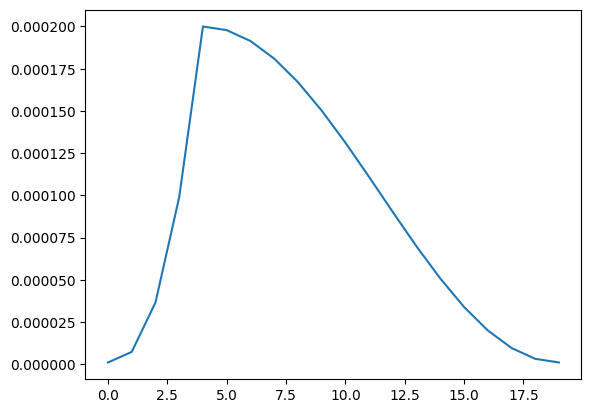

In [6]:
# For infos on LR scheduler please refer to https://www.kaggle.com/markwijkhuizen/tf-efficientnetb4-mixup-cutmix-gridmask-cv-0-90)
def lrfn(epoch, bs=BATCH_SIZE, epochs=20):

    LR_START = 1e-6
    LR_MAX = 2e-4
    LR_FINAL = 1e-6
    LR_RAMPUP_EPOCHS = 4
    LR_SUSTAIN_EPOCHS = 0
    DECAY_EPOCHS = epochs  - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
    LR_EXP_DECAY = (LR_FINAL / LR_MAX) ** (1 / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1))

    if epoch < LR_RAMPUP_EPOCHS:
        lr = LR_START + (LR_MAX + LR_START) * (epoch / LR_RAMPUP_EPOCHS) ** 2.5
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        epoch_diff = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        decay_factor = (epoch_diff / DECAY_EPOCHS) * math.pi
        decay_factor= (tf.math.cos(decay_factor).numpy() + 1) / 2        
        lr = LR_FINAL + (LR_MAX - LR_FINAL) * decay_factor

    return lr

import matplotlib.pyplot as plt  
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)

# Efficientnet B4 with NoisyStudent weights
EfficientNetB4 is finetuned based on pretrained NoisyStudent weights. Weights can e.g. be downloaded from the official[ Googleapi site](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b4.tar.gz).
The checkpoint files can be transformed to an .h5 file using the code from the [Tensorflow Github page ](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet).

In the Cassava Classification Challenge, the use of NoisyStudent only led to a very small increase in performance.


In [7]:
from tensorflow.keras.applications import EfficientNetB4

def efficientnetb4(weights="../input/cassava-leaf-disease-efficientnetb4/efficientnetb4_noisystudent_notop.h5/efficientnetb4_noisystudent_notop.h5",
                   dropout=(0.4, 0.5)):
    
    keras.backend.reset_uids()
    
    efficientnet = EfficientNetB4(weights=weights, include_top=False,
                                  input_shape=(*img_size, 3), drop_connect_rate=dropout[0])
    
    for layer in reversed(efficientnet.layers):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True
    
    inputs = keras.layers.Input(shape=(*img_size, 3))
    
    efficientnet = efficientnet(inputs)
    pooling = keras.layers.GlobalAveragePooling2D()(efficientnet)
    dropout = keras.layers.Dropout(dropout[1])(pooling)
    outputs = keras.layers.Dense(5, activation="softmax")(dropout)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model
efficientnetb4()

We did experiments with different approaches to handle the imbalanced and noisy data. It turned among all tested loss functions, sigmoid focal crossentropy worked best especially if combined with label smoothing (factor 0.1).

You can find more info on the loss on the [TF Addon page ](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy)

In [8]:
#@tf.function
def sigmoid_focal_crossentropy(y_true, y_pred, alpha=0.25, gamma=2.0):
    
    def smooth(y, smooth_factor):
        assert len(y.shape) == 2
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
        return y
    
    #label smoothing factor
    FACTOR = 0.1
    alpha_factor = 1.0
    modulating_factor = 1.0

    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.convert_to_tensor(smooth(y_true, FACTOR), dtype=y_pred.dtype)

    ce = K.binary_crossentropy(y_true, y_pred, from_logits=False)

    p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
    
    alpha = tf.convert_to_tensor(alpha, dtype=K.floatx())
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)

    gamma = tf.convert_to_tensor(gamma, dtype=K.floatx())
    modulating_factor = tf.pow((1.0 - p_t), gamma)

    return tf.reduce_sum(alpha_factor * modulating_factor * ce, axis=-1)

# 5-Fold CV Training for finding best number of epochs
We used the same CV splits for almost all models to make it easier to build and evaluate ensembles later with the OOF predictions.<br>
<code>
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
filenames = [train_path + f for f in os.listdir(train_path)]
folds = {}
for fold, (train_idx, val_idx) in enumerate(kfold.split(filenames)):
  folds[fold] = {"split": (np.take(filenames, train_idx), np.take(filenames, val_idx))}
</code>
<br>
Since the training lasted several hours, we performed the training for each fold individually.

In [9]:
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
folds = joblib.load("../input/cassava-leaf-disease-efficientnetb4/folds.pkl")


In [16]:
cv_history = []

#Considered folds of current iteration
current_folds = [0,1,2,3,4]
path = GCS_PATH + '/train_tfrecords/'

for fold, settings in dict(map(lambda k: (k, folds[k]), current_folds)).items():
  

  #tf.tpu.experimental.initialize_tpu_system(tpu)

  validation_records = tf.data.TFRecordDataset(
      [path + f.split("/")[-1] for f in settings["split"][1]], num_parallel_reads=AUTOTUNE)
    
  train_records = tf.data.TFRecordDataset(
      [path + f.split("/")[-1] for f in settings["split"][0]], num_parallel_reads=AUTOTUNE)
  train_records = train_records.with_options(ignore_order)

  validation_data = get_validation_dataset(validation_records, BATCH_SIZE, img_size, train=True) 
  train_data = get_training_dataset(train_records, BATCH_SIZE, img_size)
  
  train_size = get_tfrecord_size(train_records)
  validation_size = get_tfrecord_size(validation_records)

  with strategy.scope():
    
    model = efficientnetb4()
    # Adapt normalization layer to mean and std of dataset
    model.get_layer('efficientnetb4').get_layer('normalization').adapt(get_normalization_batch(train_records, BATCH_SIZE, img_size))
    
    opt = keras.optimizers.Adam(lr=LR)
    model.compile(loss=sigmoid_focal_crossentropy, optimizer=opt, metrics=["categorical_accuracy"])

  model.summary()
    
  cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(f"backup_fold{fold}.h5",monitor="val_categorical_accuracy", verbose=1, save_best_only=True)
  cb_earlystop = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', 
                       patience=4, restore_best_weights=True, verbose=1)

  cb_lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=1)

  params = {"epochs":EPOCHS, "steps_per_epoch":train_size//BATCH_SIZE,
            "validation_data": validation_data,
            "callbacks": [cb_earlystop, cb_checkpoint, cb_lr]} 
  
  print(f"Fold: {fold}, {train_size} train images {validation_size} validation images")

  history = model.fit(train_data, **params)
    
  cv_history.append(history.history)

KeyboardInterrupt: 

# Training on all data with 14 epochs
The model for the final submission was trained with 14 epochs. We only increased the best average epoch of the CV folds by ~25% because we have more data when training without a validation set.

In [17]:
train_records = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTOTUNE)
train_records = train_records.with_options(ignore_order)

train_data = get_training_dataset(train_records, BATCH_SIZE, img_size)
train_size = get_tfrecord_size(train_records)
train_records = tf.data.TFRecordDataset(
      [path + f.split("/")[-1] for f in settings["split"][0]] + [path + f.split("/")[-1] for f in settings["split"][1]], num_parallel_reads=AUTOTUNE)
train_records = train_records.with_options(ignore_order)
trec = train_records

with strategy.scope():
    model = efficientnetb4()
    model.get_layer('efficientnetb4').get_layer('normalization').adapt(get_normalization_batch(trec, BATCH_SIZE, img_size))
    opt = keras.optimizers.Adam(lr=LR)
    model.compile(loss=sigmoid_focal_crossentropy, optimizer=opt, metrics=["categorical_accuracy"])
    
model.summary()

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=1)
params = {"epochs": 14, "steps_per_epoch":train_size//BATCH_SIZE, "callbacks": [lr_callback]} 
  
print(f"Training on whole data using {train_size} images")
history = model.fit(train_data, **params)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 16, 16, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,788
Trainable params: 17,432,381
Non-trainable params: 250,407
_________________________________________________________________
Training on whole data using 21397 images
Epoch 1/14

Epoch 00001: LearningRateScheduler reducing learning ra

In [2]:
from tensorflow.keras.models import load_model

# 1. 在本地載入 .h5 模型（你本地環境已支援 groups=1）
model = load_model("eff_B4.h5", compile=False)

# 2. 以 SavedModel 格式儲存（Keras 3 的標準格式）
model.save("converted_model", save_format="tf")

INFO:tensorflow:Assets written to: converted_model\assets


INFO:tensorflow:Assets written to: converted_model\assets
